In [4]:
using Distributions
using Plots
using Base
using Random
using DifferentialEquations
using LinearAlgebra
#using Pkg
#Pkg.add("BenchmarkTools")
using BenchmarkTools

In [5]:
#Define the Lorenz Equations and obtain "truth" simulations
function parameterized_lorenz(du,u,p,t)
 du[1] = p[1]*(u[2]-u[1])
 du[2] = u[1]*(p[2]-u[3]) - u[2]
 du[3] = u[1]*u[2] - p[3]*u[3]
end
u0 = [14.0;14.0;15.0]
u0 = [1.306224467503526 , 2.35819267065729 ,10.902873786936706]
tspan = (0.0,100000.0)
p = [10.0,28.0,8/3]
prob1 = ODEProblem(parameterized_lorenz,u0,tspan,p)
dt = 0.01
alg = RK4()
#alg = Tsit5()
sol = solve(prob1,alg,adaptive=false,dt=dt);
#plot(sol,vars=(:1))
#statistical error
size = length(sol.t)
#estimates of statistical error
#by symmetry the long time average of x and y should be zero
#the long time average of z should equal the long time average of x*y / b
error1 = mean(sol[1,:]) / maximum(sol[1,:])
error2 = mean(sol[2,:]) / maximum(sol[2,:])
error3 = (mean(sol[3,1:Int(floor(size/2))]) - mean(sol[3,Int(floor(size/2)):size]))/ maximum(sol[3,:])
avg_z_trth = mean(sol[3,:])
#calculate statistical error
println(error1)
println(error2)
println(error3)

-0.0005498831380436096
-0.00039619485332607126
-0.00011441570959144727


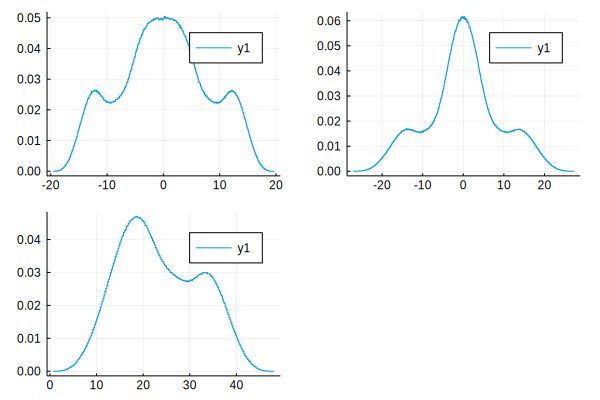

In [6]:
p1=histogram(sol[1,:],normalize=true)
p2=histogram(sol[2,:],normalize=true)
p3=histogram(sol[3,:],normalize=true)

plot(p1,p2,p3)

In [7]:
#Build the loss function, also return last timestep
#Here we use the Nusselt number (which is proportional to the long time average of z) as our metric of goodness

function loss_function(sig,r,u0)
    p = [sig,r , 8/3]
    tspan = (0.0,500.0) #shorter time for practicality
    if ( (sig < 30) & (sig > 2 ) )& ( (r>1) & (r<50))
        prob1 = ODEProblem(parameterized_lorenz,u0,tspan,p)
        sol2 = solve(prob1,alg,adaptive=false,dt=0.01);
        size = length(sol2.t)
        u1 = sol2[end]
        z_comp = mean(sol2[3,Int(floor(size/2)):size])
        return (z_comp/avg_z_trth - 1)^2 , u1
    else
        return Inf, u1
    end
end

loss_function (generic function with 1 method)

In [8]:
#Test loss function
u0 = [1.306224467503526 , 2.35819267065729 ,10.902873786936706]
val , u0 = loss_function(10,28,u0)

(3.567516753661452e-7, [5.65033, -0.855937, 31.4204])

In [9]:
@btime loss_function(10,28,u0)

  22.114 ms (250424 allocations: 25.02 MiB)


(2.6899094269405458e-6, [3.70972, 0.0401434, 27.1591])

In [55]:
#Now to do MCMC
#set initial condition for the simulation
u0 = [1.306224467503526 , 2.35819267065729 ,10.902873786936706]
num_sim = 10000
plist = zeros(num_sim,2)
vlist = zeros(num_sim)
p0 = [15,20] #starting values for MCMC
x = zeros(num_sim)
#set initial value
plist[1,:] = p0
val_old,u0 = loss_function(p0[1],p0[2],u0)
vlist[1]  = val_old
eps = 10
#apply MCM algorithm
for i in 1:(num_sim-1)
    xc = plist[i,:] + rand(Normal(0, 3), 2)
    r = rand(Uniform(0,1),1)
    log_r = log(r[1])
    val_new , u1 = loss_function(xc[1],xc[2],u0)
    log_ratio = -eps*(val_new - val_old)
    log_r < log_ratio ? plist[i+1,:]=copy(xc) : plist[i+1,:] = copy(plist[i,:])
    val_old = val_new
    vlist[i+1] = val_old
end

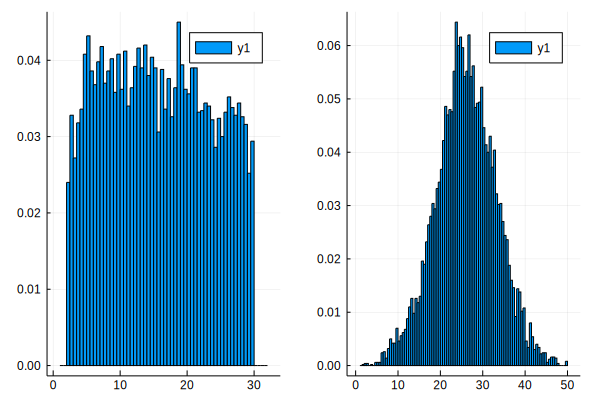

In [104]:
bins = collect(1:0.5:32)
p1 = histogram(plist[:,1],normalize=true,bins = bins)

bins = collect(1:0.5:50)
p2 = histogram(plist[:,2],normalize=true,bins = bins)
plot(p1,p2)

In [68]:
scatter(plist[:,1],plist[:,2])

In [69]:
scatter(plist[:,2],vlist)

In [70]:
findmin(vlist)
plist[length(vlist),:]

2-element Array{Float64,1}:
 23.51405560300559
 24.46046733344044

In [93]:
ranlist = rand(1:length(vlist),100)
vlist[ranlist]

100-element Array{Float64,1}:
   0.06628839549314688  
   0.023009294834132027 
 Inf                    
   0.0021726514041362226
   0.0011612165447038244
   0.07594861806663794  
   0.0019971189324881388
   0.13891594961877363  
   0.06852835967796712  
   0.17552032944823823  
   0.14780478110310702  
   0.027150959682422482 
   0.43431057745012674  
   ⋮                    
   0.04965407944614562  
   0.061429728040611205 
   0.0019994505748894015
   0.01584452650572868  
   0.0007460933222094291
   0.052118485369816114 
   0.2636992484218537   
   0.3979813293364037   
   0.4871891386970272   
   0.29293420654033736  
   0.019354249498375595 
   0.0005275300911675963

In [94]:
interpolate_v = vlist[ranlist]
interpolate_density = exp.(-eps*interpolate_v)
interpolate_p = plist[ranlist,:]

100×2 Array{Float64,2}:
  4.94614  30.6111 
 10.2837   31.5223 
  4.83368  31.7749 
 19.5163   25.6459 
  7.73586  27.8118 
 21.7225   34.7939 
  8.32337  29.5212 
 10.8977   36.5312 
  4.94027  23.597  
  6.07517  14.6827 
 23.5565   37.4443 
 19.2496   20.6681 
 25.8514    9.02942
  ⋮                
  6.61579  19.3009 
 20.4227   18.7118 
 16.4382   25.6012 
 17.3367   21.5841 
  6.92467  29.7412 
  5.27498  36.6818 
 14.5118   39.7825 
 20.4539    9.69265
  8.63974   9.20834
 14.5763   36.9573 
 17.5897   21.2722 
 12.6786   27.4108 

In [95]:
nn = length(interpolate_density)
mat = ones(nn,nn)

for j in 1:nn
    y = interpolate_p[j,:]
    for i in 1:nn
        x = interpolate_p[i,:]        
        mat[i,j] = norm(x-y)      
    end
end
        

In [96]:
gamma = 1.0
sigma = 0.1
I = one(ones(nn,nn))
kernel = ones(nn,nn)
@. kernel = exp(-gamma*mat^2) + sigma * I
alpha = kernel \ interpolate_density

100-element Array{Float64,1}:
  0.301593920310273   
  0.7025431911282034  
 -0.10185638526698973 
  0.8842917636820048  
  0.7181737825057157  
  0.42534794041353    
  0.5493869648290862  
  0.2265669836927246  
 -0.13916913255945634 
  0.15715651154407495 
  0.20733583187765672 
  0.6036871988938637  
  0.01181232481697993 
  ⋮                   
  0.5674261711360424  
  0.4133645060375087  
  0.5725458830313612  
  0.505237224493628   
  0.343704928924468   
  0.5398294455857828  
  0.06505426383514153 
  0.016990098013910878
  0.006962558965064168
  0.04855435729492519 
  0.2708854964439208  
  0.8738826708843311  

In [97]:
function marginal_sigma(sigma)
    y = 0
    for i in 1:nn
        y += alpha[i]*exp(-gamma*(sigma-interpolate_p[i,1])^2)
    end
    return y
end

function marginal_r(r)
    y = 0
    for i in 1:nn
        y += alpha[i]*exp(-gamma*(r-interpolate_p[i,2])^2)
    end
    return y
end

marginal_r (generic function with 1 method)

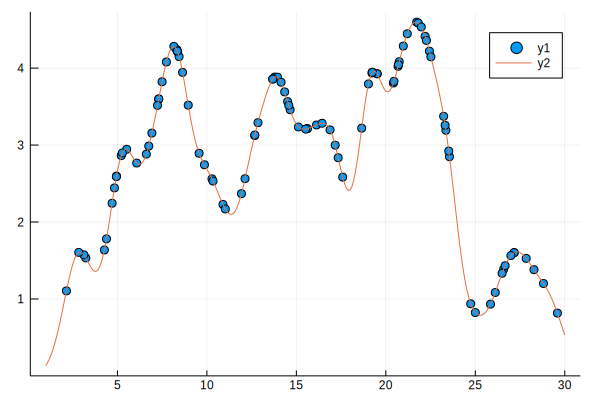

In [101]:
sigma = interpolate_p[:,1]
tmp = marginal_sigma.(sigma)
scatter(sigma, tmp)
#scatter!(sigma, interpolate_density)
plot!(1:0.1:30,marginal_sigma.(1:0.1:30))

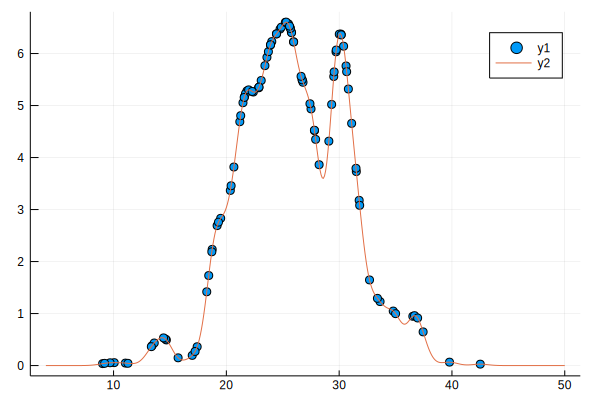

In [99]:
r = interpolate_p[:,2]
tmp = marginal_r.(r)
scatter(r, tmp)
#scatter!(r, interpolate_density)
plot!(4:0.1:50,marginal_r.(4:0.1:50))